# Physics Informed Neural Networks applied to Inverse Obstacle Problem on the Stokes System




## Load the data

The experimental data was generated using the tools of Matlab and FreeFem. Next, the data was loaded for use in the model.




In [ ]:
# Imports
import os
# Data Processing
import pandas as pd
import numpy as np
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

We load the data of the Cauchy Tensor in a DataFrame that we generates on FreeFem++

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Descomprimir imagenes

In [ ]:
!unzip "/content/drive/MyDrive/cristobal.alvarez@sansano.usm.cl 2023-07-21 13:46/Seminario de Tesis/3.zip" -d "content" # unzip the obstacles
os.rename('/content/content/images','/content/content/3')

!unzip "/content/drive/MyDrive/cristobal.alvarez@sansano.usm.cl 2023-07-21 13:46/Seminario de Tesis/4.zip" -d "content" # unzip the obstacles
os.rename('/content/content/images','/content/content/4')

!unzip "/content/drive/MyDrive/cristobal.alvarez@sansano.usm.cl 2023-07-21 13:46/Seminario de Tesis/5.zip" -d "content" # unzip the obstacles
os.rename('/content/content/images','/content/content/5')

!unzip "/content/drive/MyDrive/cristobal.alvarez@sansano.usm.cl 2023-07-21 13:46/Seminario de Tesis/6.zip" -d "content" # unzip the obstacles
os.rename('/content/content/images','/content/content/6')

!unzip "/content/drive/MyDrive/cristobal.alvarez@sansano.usm.cl 2023-07-21 13:46/Seminario de Tesis/circles-20221226T000928Z-001.zip" -d "content" # unzip the obstacles

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: content/circles/c_4985.png  
  inflating: content/circles/c_5011.png  
  inflating: content/circles/c_4988.png  
  inflating: content/circles/c_5006.png  
  inflating: content/circles/c_4999.png  
  inflating: content/circles/c_4989.png  
  inflating: content/circles/c_4987.png  
  inflating: content/circles/c_4991.png  
  inflating: content/circles/c_5005.png  
  inflating: content/circles/c_4979.png  
  inflating: content/circles/c_4976.png  
  inflating: content/circles/c_4986.png  
  inflating: content/circles/c_4983.png  
  inflating: content/circles/c_4990.png  
  inflating: content/circles/c_4973.png  
  inflating: content/circles/c_4981.png  
  inflating: content/circles/c_4978.png  
  inflating: content/circles/c_4984.png  
  inflating: content/circles/c_4980.png  
  inflating: content/circles/c_4970.png  
  inflating: content/circles/c_4968.png  
  inflating: content/circles/c_4974.png  
  inflati

# DataLoaders

In [ ]:
# NUEVO DATA LOADER
# NEWS: MANEJO DE EXCEPCIONES + PRECARGA DE DATOS
# demora app 40min en cargar toda la data pero lo hace 1 sola vez
from math import e
path = '/content/drive/MyDrive/cristobal.alvarez@sansano.usm.cl 2023-07-21 13:46/Seminario de Tesis/Geometrias'
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, csv_files, image_dirs, transform=None):
        self.dataframes = [pd.read_csv(file) for file in csv_files]
        self.image_dirs = image_dirs
        self.transform = transform
        # Concatena todos los DataFrames y reinicia el índice
        self.dataframe = pd.concat(self.dataframes, ignore_index=True)
        # Precargar imágenes y datos
        self.images = []
        self.csv_data_list = []
        for idx in range(len(self.dataframe)):
            folder_name = self.dataframe.iloc[idx,-1][0].split('_')[0]
            img_name = self.dataframe.iloc[idx,-1]
            if folder_name == 'c':
                folder_name = 'circles'
                img_name = img_name.replace('.pgm','.png')
            else:
                img_name = img_name.split('_')[-1]
            img_path = os.path.join(self.image_dirs[folder_name], img_name)
            # si la imagen no existe, seguir con la sgte
            if not os.path.exists(img_path):
                continue
            image = Image.open(img_path).convert('L')
            if self.transform:
                image = self.transform(image)
            csv_data = self.dataframe.iloc[idx, :-1]
            if csv_data.shape[-1]!=200:
                csv_data = self.dataframe.iloc[idx, 1:-1]
            csv_tensor = torch.tensor(csv_data, dtype=torch.float32)
            self.images.append(image)
            self.csv_data_list.append(csv_tensor)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index], self.csv_data_list[index]


# Aplicar transformaciones
transform = transforms.Compose([
    transforms.Resize((144,144)),
    transforms.ToTensor()
])

# Rutas a tus archivos CSV y carpetas de imágenes
#csv_files = [path+"/6_data.csv", path+"/5_data.csv", path+"/4_data.csv", path+"/3_data.csv", path+"/circles_data.csv"]
#image_dirs = {"6": "/content/content/6", "5": "/content/content/5", "4": "/content/content/4", "3": "/content/content/3", "circles":"/content/content/circles"}
csv_files = [path+"/3_data.csv"]
image_dirs = { "3": "/content/content/3"}

dataset = CustomDataset(csv_files=csv_files, image_dirs=image_dirs, transform=transform)


In [ ]:
# Dividir el conjunto de datos
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

In [ ]:
batch_size = 256
# Ahora, puedes crear tus DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=2)


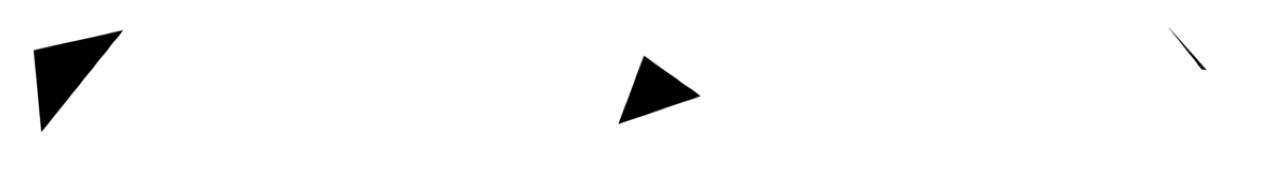

In [ ]:
data_iter = iter(valid_loader)
try:
    images, csv_data = next(data_iter)
except StopIteration:
    data_iter = iter(valid_loader)
    images, csv_data = next(data_iter)

indices = torch.randint(0, len(images), (3,))
# Mostrar obstaculos aleatorios
fig,axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,2))
for ax, idx in zip(axes, indices):
    ax.imshow(np.transpose(images[idx].numpy(), (1,2,0)), cmap="gray")
    ax.axis("off")
plt.show()

Lets gonna make some visualizations around the obstacles

In [ ]:
class MinMaxNormalizeTransform:
    """
    Transformación personalizada para normalizar usando la estrategia Min-Max.
    """
    def __init__(self, data_min, data_max):
        self.data_min = data_min
        self.data_max = data_max

    def __call__(self, data):
        output, input_data = data
        normalized_input = (input_data - self.data_min) / (self.data_max - self.data_min)
        return output, normalized_input

def compute_min_max(loader):
    """
    Calcula los valores mínimos y máximos de un DataLoader.
    """
    data_min = float('inf') * torch.ones(200)
    data_max = float('-inf') * torch.ones(200)
    for _, input_data in loader:
        input_data = torch.tensor(input_data)  # Convertir el dataframe a tensor
        batch_min, _ = input_data.min(dim=0)
        batch_max, _ = input_data.max(dim=0)
        data_min = torch.min(data_min, batch_min)
        data_max = torch.max(data_max, batch_max)

    return data_min, data_max

# Calcular el mínimo y máximo para el conjunto de entrenamiento
train_min, train_max = compute_min_max(train_loader)

# Crear y aplicar la transformación de normalización Min-Max
min_max_transform = MinMaxNormalizeTransform(data_min=train_min, data_max=train_max)
composed_transforms = transforms.Compose([min_max_transform])  # Añadir otras transformaciones si es necesario

# Aplicar la transformación al dataset
train_dataset.transform = composed_transforms
valid_dataset.transform = composed_transforms


<ipython-input-9-e5cd921077c3>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(input_data)  # Convertir el dataframe a tensor


In [ ]:
torch.save({
    'data_min': train_min,
    'data_max': train_max
}, 'data_min_max.pt')


# Deep Learning model to approximate the DN Map

In [ ]:
import torch
# Verificar disponibilidad de GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import torch.nn as nn

class ConcatCNN(nn.Module):

    def __init__(self, dropout_rate=0.3):
        super().__init__()

        # Capas completamente conectadas (Lineales)
        self.decoder_lin = nn.Sequential(
            nn.Linear(200, 300),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),

            nn.Linear(300, 600),
            nn.ReLU(True),

            nn.Dropout(dropout_rate),
            nn.Linear(600, 1200),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),


            nn.Linear(1200, 16 * 18 * 18),
            nn.ReLU(True),
            nn.Dropout(dropout_rate))

        # "Unflatten" para devolver a la forma tensorial
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 18, 18))

        # Transposed Convolutions (Deconvolutions)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3, stride=2, output_padding=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),

            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),

            nn.ConvTranspose2d(64, 1, 5, stride=1, padding=2, output_padding=0),
            nn.Sigmoid()
        )

        # Capa adicional para adaptar el input a una forma adecuada
        self.input_adapter = nn.Sequential(
            nn.Linear(200, 144 * 144),  # Adapta el vector de 200 a una imagen de 144x144
            nn.ReLU(True)
        )

        # Capa convolucional extra para fusionar la información
        self.fusion_layer = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=3, stride=1, padding=1),  # 2 canales a 1 canal
            nn.Sigmoid()
        )

    def forward(self, x):
        adapted_input = self.input_adapter(x)
        adapted_input = adapted_input.view(adapted_input.size(0), 1, 144, 144)  # Cambia la forma a [batch_size, 1, 144, 144]

        x_processed = self.decoder_lin(x)
        x_processed = self.unflatten(x_processed)
        image_output = self.decoder_conv(x_processed)

        # Concatena el input adaptado con la imagen en la dimensión del canal
        fused_input = torch.cat((adapted_input, image_output), dim=1)
        final_output = self.fusion_layer(fused_input)

        return final_output
import torch.nn.init as init

def weights_initialization(model):
    """
    Aplica inicialización de pesos a las capas del modelo.
    """
    for m in model.modules():
        # Inicialización Kaiming para capas convolucionales
        if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.ConvTranspose2d):
            init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                init.constant_(m.bias, 0)

        # Inicialización Xavier para capas lineales
        if isinstance(m, torch.nn.Linear):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)

In [ ]:
from torchsummary import summary

cnn = ConcatCNN().to(device)
weights_initialization(cnn)
summary(cnn, input_size = (200,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 20736]       4,167,936
              ReLU-2                [-1, 20736]               0
            Linear-3                  [-1, 300]          60,300
              ReLU-4                  [-1, 300]               0
           Dropout-5                  [-1, 300]               0
            Linear-6                  [-1, 600]         180,600
              ReLU-7                  [-1, 600]               0
           Dropout-8                  [-1, 600]               0
            Linear-9                 [-1, 1200]         721,200
             ReLU-10                 [-1, 1200]               0
          Dropout-11                 [-1, 1200]               0
           Linear-12                 [-1, 5184]       6,225,984
             ReLU-13                 [-1, 5184]               0
          Dropout-14                 [-

In [ ]:
path = '/content/drive/MyDrive/cristobal.alvarez@sansano.usm.cl 2023-07-21 13:46/Seminario de Tesis/'

def plot_reconstructed_images(model,epoch, dataloader, ax, n = 3):
    data_iter = iter(dataloader)
    images, csv_data = next(data_iter)
    images = images.to(device)
    csv_data = csv_data.to(device)

    outputs = model(csv_data).cpu().detach()

    images = images.cpu()
    plt.suptitle(f"Reconstruction on epoch {epoch+1} over validation set")
    for index in range(1, n + 1):

        ax = plt.subplot(2, n, index)
        plt.imshow(images[index][0], cmap="gray")
        ax.axis('off')

        ax = plt.subplot(2, n, index + n)
        plt.imshow(outputs[index][0], cmap='gray')
        ax.axis('off')
    #plt.savefig(path+ f'epoch {epoch}_CNN_RES.png')
    plt.show()

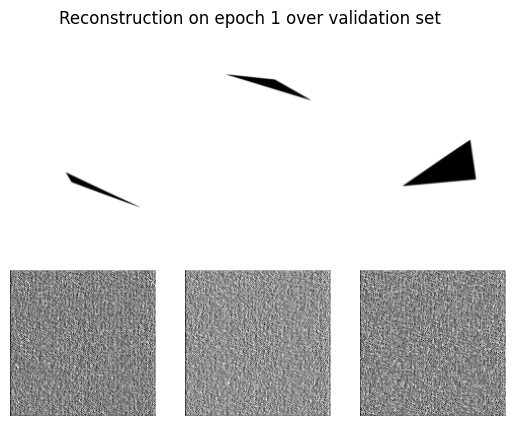

In [ ]:
plot_reconstructed_images(cnn,0, valid_loader, ax)

In [ ]:
# Usamos Weight and Bias para almacenar el rendimiento durante el entrenamiento
!pip install wandb
import wandb
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=9bb9d4a9b8dca9ebb0a856ea822e84f0bff2549610faa1b5587d37c555c84cfe
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.8 MB/s eta 0:00:00


## Hiperparameter Optimization


In [ ]:
import optuna
num_epochs = 60
def MSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

obstacle_criterion = nn.BCELoss()

l1_lambda = 1e-3
l2_lambda = 1e-4

def l1_regularizer(model):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return l1_lambda * l1_norm

def l2_regularizer(model):
    l2_norm = sum((p**2).sum() for p in model.parameters())
    return l2_lambda*l2_norm

losses = []
val_losses = []
best_val_loss = float("inf")
a1 = 1e-3
a2 = 1e-2

def objective(trial):
    # Inicializa wandb
    wandb.init(project='hip-opt-ip')

    # Sugerencias de hiperparámetros
    batch_size = trial.suggest_int("batch_size", 128, 1024, log=True)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-9, 1e-3)
    learning_rate = trial.suggest_loguniform("lr", 1e-6, 1e-2)

    # Configura los DataLoaders con el nuevo batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Crea el modelo y define el optimizador con los hiperparámetros sugeridos
    cnn = ConcatCNN().to(device)
    weights_initialization(cnn)
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate, weight_decay=weight_decay)
    losses = []
    val_losses = []
    best_val_loss = float("inf")

    # Aquí iría tu bucle de entrenamiento, pero recuerda agregar la siguiente línea
    # para registrar el resultado en wandb y optuna:
    for epoch in range(num_epochs):
        cnn.train()
        epoch_loss = 0
        t = enumerate(train_loader)
        for i, (img_batch,csv_data_batch) in t:
            img_batch = img_batch.cpu().to(device)
            csv_data_batch = csv_data_batch.cpu().to(device)

            # Forward pass
            outputs = cnn(csv_data_batch).cpu().to(device)

            # Calcular funcion de perdida
            obstacle_reconstruction = obstacle_criterion(outputs, img_batch)
            l1_loss = l2_regularizer(cnn)
            total_loss = obstacle_reconstruction  #+ l1_loss
            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()

        # Validation loop
        cnn.eval()
        epoch_val_loss = 0
        obstacle_rec= 0
        with torch.no_grad():
            plot_reconstructed_images(cnn, epoch, train_loader, ax=ax)
        v = enumerate(valid_loader)
        for i, (img_batch,csv_data_batch) in v:
            img_batch = img_batch.to(device)
            csv_data_batch = csv_data_batch.to(device)

            with torch.no_grad():
                outputs = cnn(csv_data_batch)

            obstacle_reconstruction = obstacle_criterion(outputs, img_batch)
            l1_loss = l2_regularizer(cnn)

            val_loss = obstacle_reconstruction  #+ l1_loss
            epoch_val_loss += val_loss.item()
            obstacle_rec += MSELoss(outputs, img_batch)

        epoch_loss /= len(train_loader)
        epoch_val_loss /= len(valid_loader)
        obstacle_rec /= len(valid_loader)
        losses.append(epoch_loss)
        val_losses.append(epoch_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {epoch_loss}, Validation Loss: {epoch_val_loss:.6f}, Obstacle reconstruction: {obstacle_rec:.6f}")

        if best_val_loss > epoch_val_loss:
            best_val_loss = epoch_val_loss
            path = '/content/drive/MyDrive/cristobal.alvarez@sansano.usm.cl 2023-07-21 13:46/Seminario de Tesis/'
            #torch.save(cnn.state_dict(), path + "CNN_RES.pth")

        wandb.log({"Train Loss": epoch_loss, "Validation Loss": epoch_val_loss,
                "obstacle_reconstruction":obstacle_rec, "batch size": batch_size,
                   "weight decay": weight_decay, "learning rate": learning_rate })

        trial.report(epoch_val_loss, epoch)  # reporta el loss de validación a Optuna
    wandb.finish()
    return epoch_val_loss


In [ ]:
wandb.finish()

Train Loss,█▆▅▄▃▂▂▁▁▁▁▁
Validation Loss,█▆▅▄▃▂▂▂▁▁▁▁
obstacle_reconstruction,█▇▆▅▄▃▂▂▂▁▁▁
Train Loss,0.5136
Validation Loss,0.5089
obstacle_reconstruction,0.35674


[I 2023-10-30 02:17:18,020] A new study created in memory with name: no-name-017e83f6-b071-4f0e-9803-27be7aef7140


<ipython-input-32-2b7689b2470e>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-9, 1e-3)
<ipython-input-32-2b7689b2470e>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-6, 1e-2)


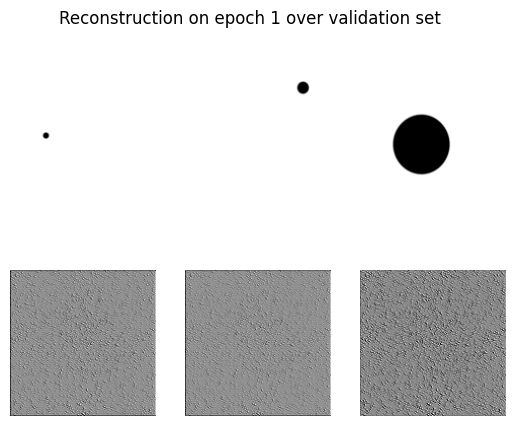

Epoch [1/60],Train Loss: 2.381129578307823, Validation Loss: 1.826792, Obstacle reconstruction: 0.517014


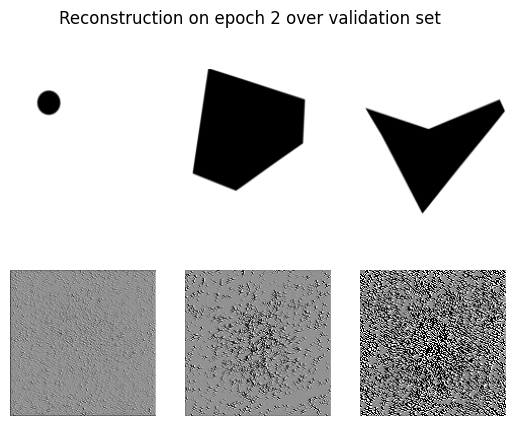

Epoch [2/60],Train Loss: 1.418200179382607, Validation Loss: 1.096545, Obstacle reconstruction: 0.472955


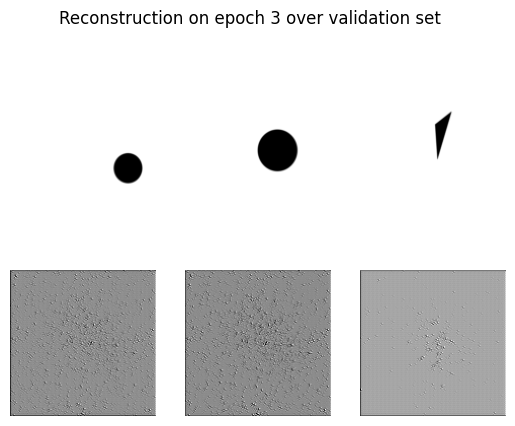

Epoch [3/60],Train Loss: 0.889741266215289, Validation Loss: 0.793403, Obstacle reconstruction: 0.448777


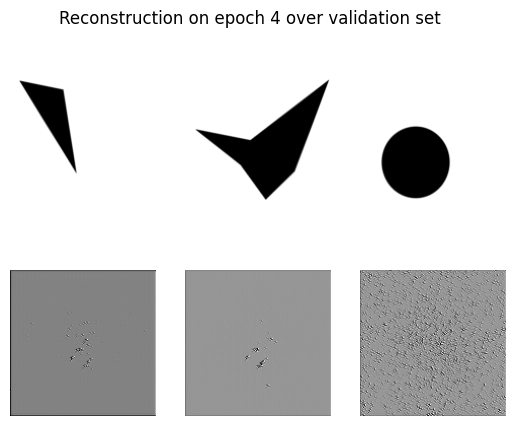

Epoch [4/60],Train Loss: 0.7048268649313185, Validation Loss: 0.677598, Obstacle reconstruction: 0.435153


In [ ]:
from optuna.samplers import TPESampler

# Crea el estudio con el sampler TPESampler (Tree-structured Parzen Estimator)
sampler = TPESampler()

study = optuna.create_study(direction="minimize", sampler = sampler)
study.optimize(objective, n_trials=100)

In [ ]:
print("Número de trials terminados: ", len(study.trials))
print("Mejor trial:")
trial = study.best_trial

print("  Valor: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")



In [ ]:
wandb.init(project = 'Deep Optimization TPE')

## Deep Optimization

In [ ]:
from IPython.display import clear_output
import datetime

cnn = ConcatCNN().to(device)
weights_initialization(cnn)
batch_size = 227
learning_rate = 0.001051276
wd = 2.89921067e-8
def MSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

obstacle_criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate, weight_decay=wd)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

l1_lambda = 1e-3
l2_lambda = 1e-4

def l1_regularizer(model):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return l1_lambda * l1_norm

def l2_regularizer(model):
    l2_norm = sum((p**2).sum() for p in model.parameters())
    return l2_lambda*l2_norm

num_epochs = 700
losses = []
val_losses = []
best_val_loss = float("inf")
a1 = 1e-3
a2 = 1e-2
fig, ax = plt.subplots(1, 2)

fig.suptitle('CNN Training - Obstacle reconstruction on the Stokes System')

for epoch in range(num_epochs):
    cnn.train()
    epoch_loss = 0
    t = enumerate(train_loader)
    for i, (img_batch,csv_data_batch) in t:
        img_batch = img_batch.cpu().to(device)
        csv_data_batch = csv_data_batch.cpu().to(device)

        # Forward pass
        outputs = cnn(csv_data_batch).cpu().to(device)

        # Calcular funcion de perdida
        obstacle_reconstruction = obstacle_criterion(outputs, img_batch)
        l1_loss = l2_regularizer(cnn)
        total_loss = obstacle_reconstruction  #+ l1_loss
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()


    # Validation loop
    cnn.eval()
    epoch_val_loss = 0
    obstacle_rec= 0
    with torch.no_grad():
        plot_reconstructed_images(cnn, epoch, train_loader, ax=ax)
    v = enumerate(valid_loader)
    for i, (img_batch,csv_data_batch) in v:
        img_batch = img_batch.to(device)
        csv_data_batch = csv_data_batch.to(device)

        with torch.no_grad():
            outputs = cnn(csv_data_batch)

        obstacle_reconstruction = obstacle_criterion(outputs, img_batch)
        l1_loss = l2_regularizer(cnn)

        val_loss = obstacle_reconstruction  #+ l1_loss
        epoch_val_loss += val_loss.item()
        obstacle_rec += MSELoss(outputs, img_batch)

    epoch_loss /= len(train_loader)
    epoch_val_loss /= len(valid_loader)
    obstacle_rec /= len(valid_loader)
    losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    scheduler.step(epoch_val_loss)
    #wandb.log({"Train Loss": epoch_loss, "Validation Loss": epoch_val_loss,
    #           "obstacle_reconstruction":obstacle_rec})

    print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {epoch_loss}, Validation Loss: {epoch_val_loss:.6f}, Obstacle reconstruction: {obstacle_rec:.6f}")

    if best_val_loss > epoch_val_loss:
        best_val_loss = epoch_val_loss
        path = '/content/drive/MyDrive/cristobal.alvarez@sansano.usm.cl 2023-07-21 13:46/Seminario de Tesis/'
        torch.save(cnn.state_dict(), path + "CNN_RES_triangle.pth")

print('Finished Training')
plt.ioff()


# Model Analysis

In [ ]:
data_iter = iter(train_loader)
images, csv_data = next(data_iter)
images = images.to(device)
csv_data = csv_data.to(device)

In [ ]:
model = cnn

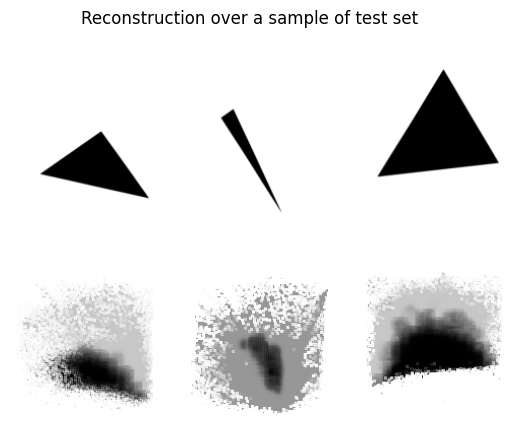

In [ ]:
outputs = model(csv_data).cpu().detach()
images = images.cpu()
n = 3

plt.suptitle(f"Reconstruction over a sample of test set")
for index in range(1, n + 1):

    ax = plt.subplot(2, n, index)
    plt.imshow(images[index][0], cmap="gray")
    ax.axis('off')

    ax = plt.subplot(2, n, index + n)
    plt.imshow(outputs[index][0], cmap='gray')
    ax.axis('off')
plt.show()


In [ ]:
len(outputs[0])

1

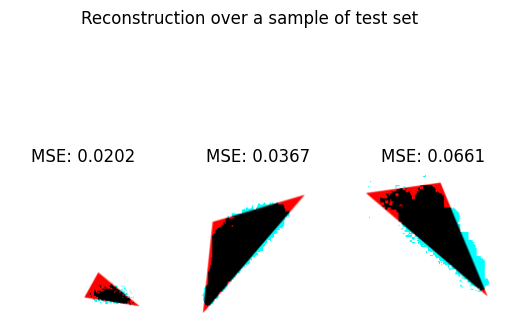

In [ ]:
import random
umbrales = np.linspace(0, 1, 300)
n = 3

def MSELoss(yhat, y):
    return torch.mean((yhat - y) ** 2)

def MSELoss(yhat, y):
    return torch.mean(torch.abs(yhat - y))

plt.suptitle(f"Reconstruction over a sample of test set")
for index in range(n):
    idx = random.randint(0,len(outputs))
    imagen = outputs[idx][0]

    # Calcular el MSE para todos los umbrales y seleccionar el umbral óptimo
    mse_values = []
    for u in umbrales:
        imagen_bin = (imagen > u).float()
        mse_values.append(MSELoss(imagen_bin, images[idx][0]))

    # Encuentra el índice del umbral que tiene el menor MSE
    optimal_idx = np.argmin(mse_values)
    u_opt = umbrales[optimal_idx]

    imagen_bin = (imagen > u_opt).float().numpy()
    real_image = images[idx][0].numpy()

    # Crear una imagen combinada con la imagen real en negro y la reconstrucción en rojo
    combined_image = np.zeros((real_image.shape[0], real_image.shape[1], 3))  # 3 canales para RGB
    combined_image[:,:,0] = imagen_bin  # Canal rojo para la imagen reconstruida
    combined_image[:,:,1] = combined_image[:,:,2] = real_image  # Canales verde y azul para la imagen real

    ax = plt.subplot(1, n, index + 1)
    plt.imshow(combined_image)
    ax.title.set_text(f"MSE: {mse_values[optimal_idx]:.4f}")  # Añadir MSE como título
    ax.axis('off')

plt.show()


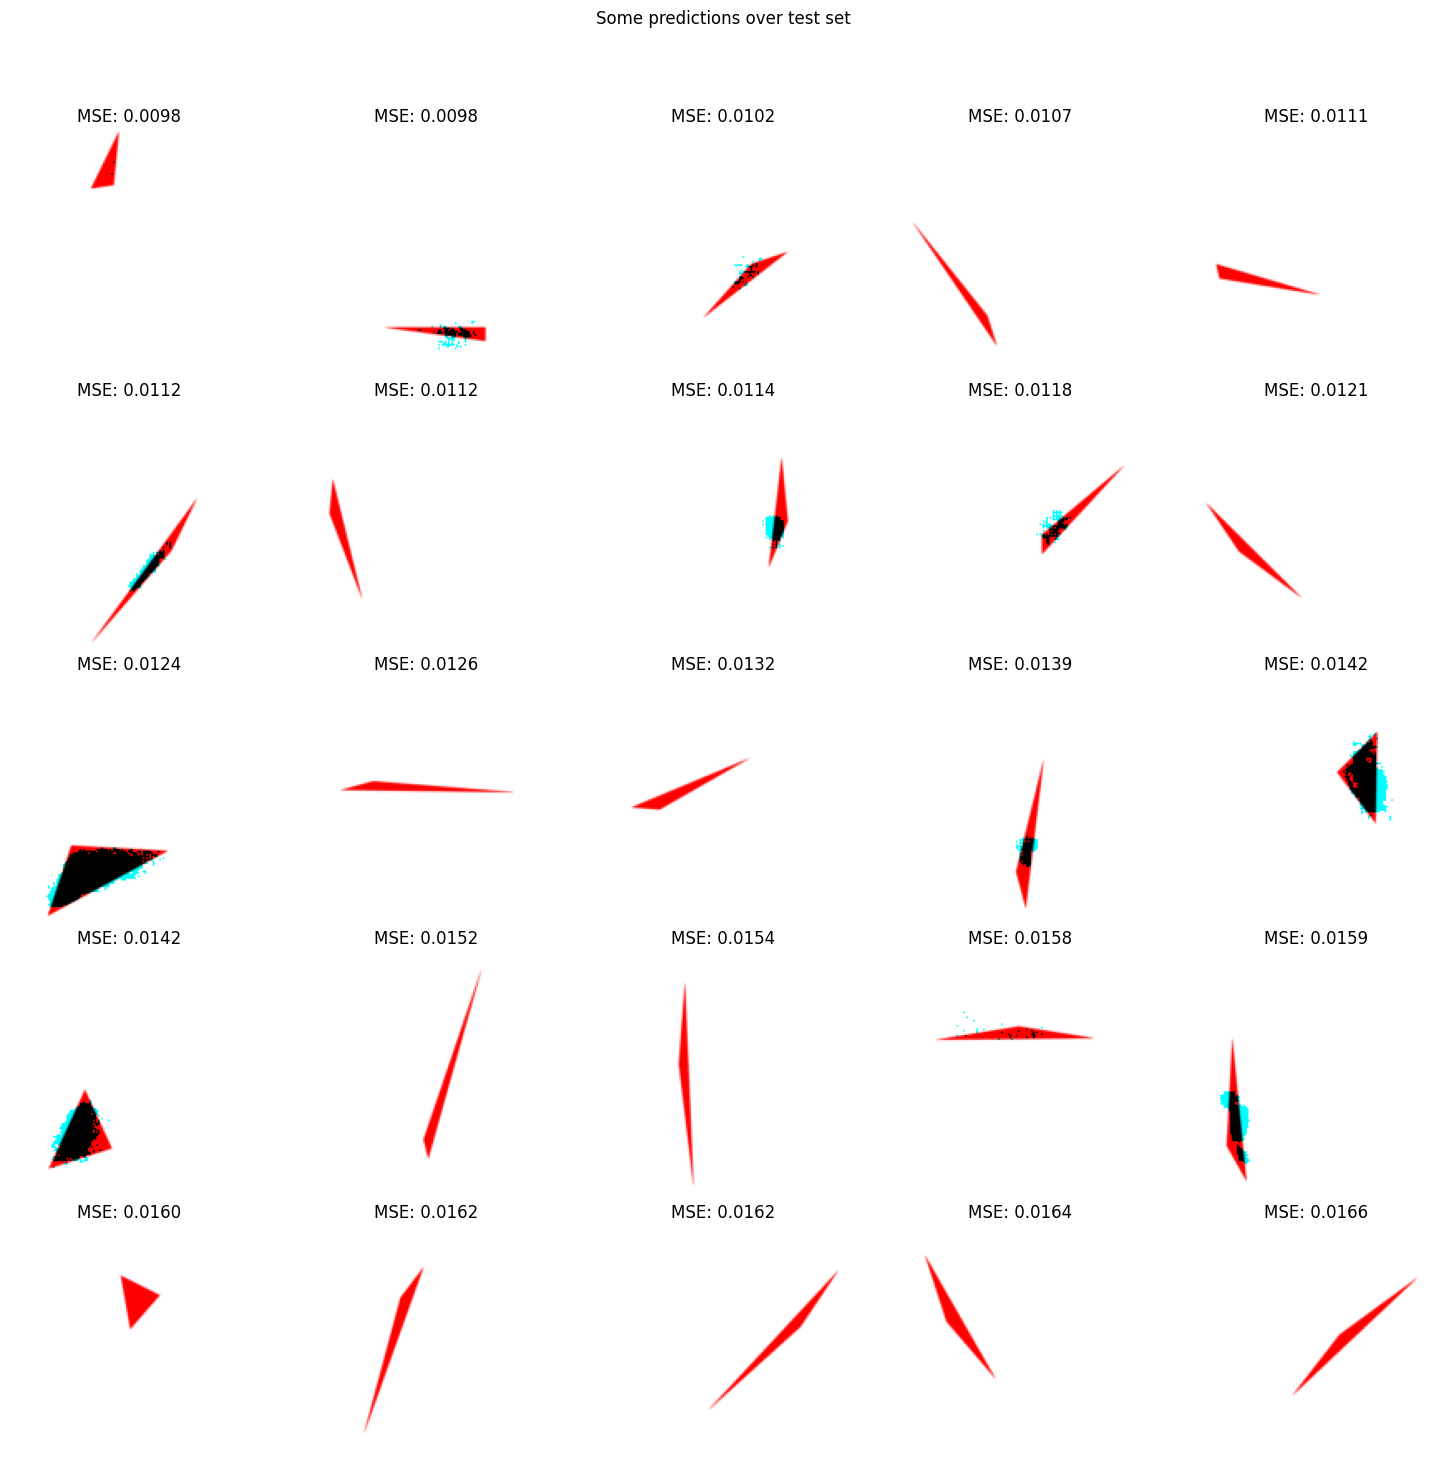

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

umbrales = np.linspace(0, 1, 300)

def MSELoss(yhat, y):
    return torch.mean((yhat - y) ** 2)

# Calcular el MSE para todas las salidas
all_mse_values = []

for idx, imagen in enumerate(outputs):
    mse_values = []
    for u in umbrales:
        imagen_bin = (imagen[0] > u).float()
        mse_values.append(MSELoss(imagen_bin, images[idx][0]))
    all_mse_values.append(min(mse_values))

# Obtener los índices de las 25 mejores predicciones (menor MSE)
best_25_indices = np.argsort(all_mse_values)[25:50]

plt.figure(figsize=(15, 15))
plt.suptitle(f"Some predictions over test set")

for count, idx in enumerate(best_25_indices):
    imagen = outputs[idx][0]

    # Calcular el MSE para todos los umbrales y seleccionar el umbral óptimo
    mse_values = []
    for u in umbrales:
        imagen_bin = (imagen > u).float()
        mse_values.append(MSELoss(imagen_bin, images[idx][0]))

    # Encuentra el índice del umbral que tiene el menor MSE
    optimal_idx = np.argmin(mse_values)
    u_opt = umbrales[optimal_idx]

    imagen_bin = (imagen > u_opt).float().numpy()
    real_image = images[idx][0].numpy()

    # Crear una imagen combinada con la imagen real y la reconstrucción
    combined_image = np.zeros((real_image.shape[0], real_image.shape[1], 3))  # 3 canales para RGB
    combined_image[:,:,0] = imagen_bin  # Canal rojo para la imagen reconstruida
    combined_image[:,:,1] = combined_image[:,:,2] = real_image  # Canales verde y azul para la imagen real

    ax = plt.subplot(5, 5, count + 1)
    plt.imshow(combined_image)
    ax.title.set_text(f"MSE: {mse_values[optimal_idx]:.4f}")  # Añadir MSE como título
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [ ]:
# Listas para almacenar los errores y la cantidad de píxeles 0
errors = []
zero_pixels = []
i = 1
for images, csv_data in test_loader:
    images = images.to(device)
    csv_data = csv_data.to(device)
    if (i-1)%10 == 0:
        print(f'Calculando error para i = {i}')
    # calcular el error
    outputs = model(csv_data).to(device)
    e = ((outputs - images) ** 2).mean(dim=(1, 2, 3))
    errors.extend(e.tolist())

    # Contar los píxeles que son 0 en cada imagen
    zero_count = (images == 0).sum(dim=(1, 2, 3)).tolist()
    zero_pixels.extend(zero_count)
    i+=1


Calculando error para i = 1


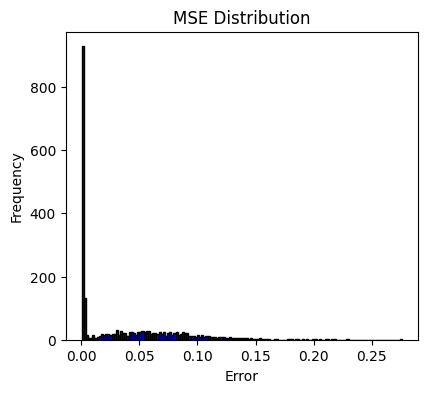

In [ ]:
# Crear histograma del error
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(errors, bins=150, color='blue', edgecolor='black')
plt.title('MSE Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

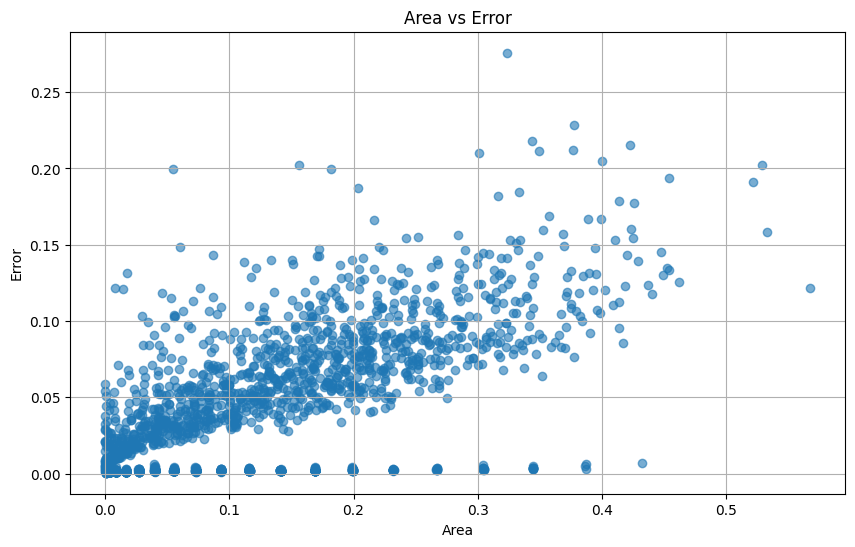

In [ ]:
area = [x/(144*144) for x in zero_pixels]
plt.figure(figsize=(10, 6))
plt.scatter(area, errors, alpha=0.6)
plt.title('Area vs Error')
plt.xlabel('Area')
plt.ylabel('Error')
plt.grid(True)
plt.show()

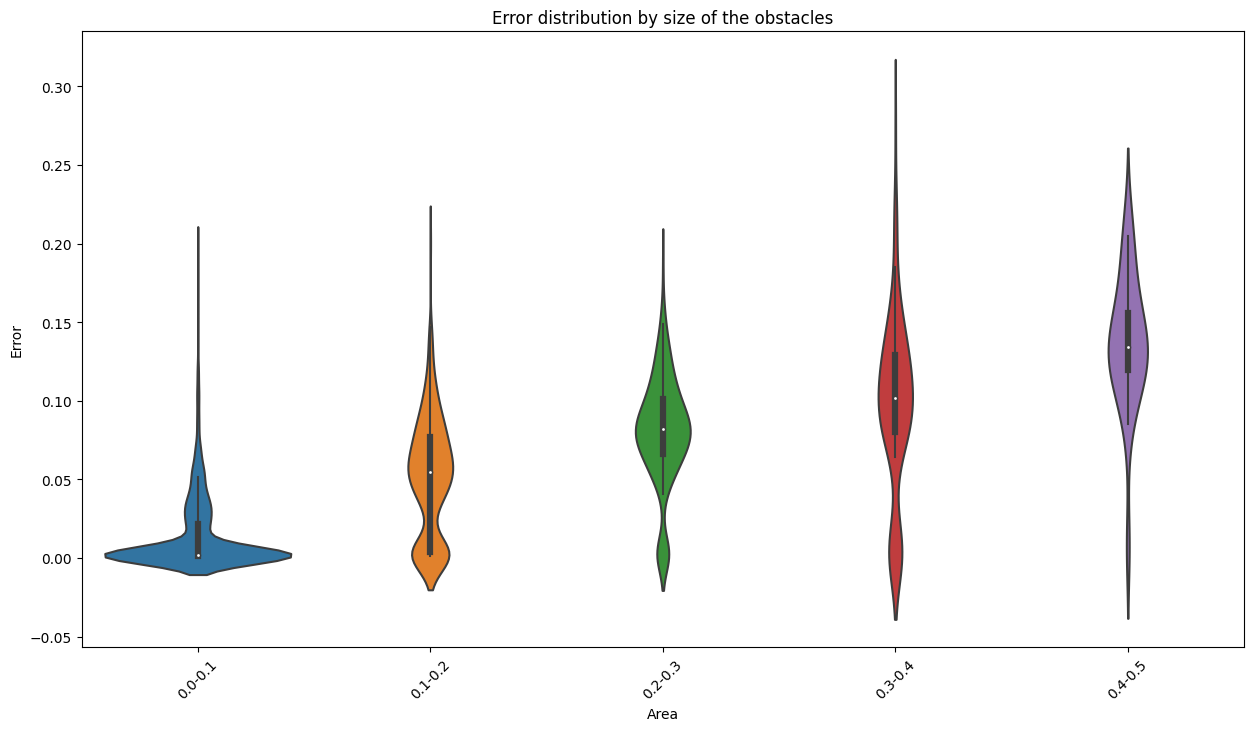

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Definir los bins y etiquetas basados en el rango [0, 0.5] con saltos de 0.1
bins = np.arange(0, 0.6, 0.1)  # Incluye 0.6 para asegurar que 0.5 esté dentro del último bin
labels = [f"{i:.1f}-{i+0.1:.1f}" for i in np.arange(0, 0.5, 0.1)]

areas_categories = pd.cut(area, bins=bins, labels=labels, right=False)

# Crear un DataFrame con las áreas categorizadas y los errores
df = pd.DataFrame({'Area': areas_categories, 'Error': errors, 'real area': area})

# Crear el violin plot
plt.figure(figsize=(15, 8))
sns.violinplot(x='Area', y='Error', data=df)
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor visualización
plt.title('Error distribution by size of the obstacles')
plt.show()


In [ ]:
df.corr()

<ipython-input-124-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Error,real area
Error,1.000000,0.747995
real area,0.747995,1.000000


## Robustness

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # Importa la versión notebook de tqdm para una mejor visualización en Jupyter

def add_noise(data, noise_factor=0.2):
    norms = torch.norm(data, dim=1, keepdim=True)
    noise = noise_factor * torch.randn_like(data) * norms
    return data + noise

# Listas para almacenar errores
errors_no_noise = []
errors_with_noise = []
zero_pixels = []


In [ ]:
def add_noise(data, noise_factor=0.2):
    norms = torch.norm(data, dim=1, keepdim=True)
    noise = noise_factor * torch.randn_like(data) * norms
    return data + noise

results = {
    'noise_level': [],
    'errors_no_noise': [],
    'errors_with_noise': [],
    'zero_pixels': []
}

noise_levels = np.linspace(0.01, 0.1, 5)

all_errors_no_noise = []
all_errors_with_noise = []
all_zero_pixels = []

for noise_factor in tqdm(noise_levels, desc="Niveles de ruido", leave=True):

    with torch.no_grad():
        for images, csv_data in test_loader:

            images = images.to(device)
            csv_data = csv_data.to(device)
            noisy_csv_data = add_noise(csv_data, noise_factor)

            outputs_no_noise = model(csv_data)
            outputs_with_noise = model(noisy_csv_data)

            # Calculamos el error para cada elemento en el batch
            errors_no_noise = ((outputs_no_noise - images) ** 2).mean(dim=(1, 2, 3)).cpu().detach().numpy().tolist()
            errors_with_noise = ((outputs_with_noise - images) ** 2).mean(dim=(1, 2, 3)).cpu().detach().numpy().tolist()

            all_errors_no_noise.extend(errors_no_noise)
            all_errors_with_noise.extend(errors_with_noise)
            zero_pixels = (images == 0).sum(dim=(1, 2, 3))
            all_zero_pixels.extend(zero_pixels.cpu().numpy())

            results['errors_no_noise'].extend(errors_no_noise)
            results['errors_with_noise'].extend(errors_with_noise)
            results['zero_pixels'].extend(zero_pixels.cpu().numpy())
            results['noise_level'].extend([noise_factor] * len(images))


Niveles de ruido:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
import plotly.express as px
import pandas as pd

# Convertir el diccionario 'results' a un DataFrame de pandas
df = pd.DataFrame(results)

# Crear el scatter plot con Plotly
fig = px.scatter(df, x='zero_pixels', y='errors_with_noise', color='noise_level',
                 hover_name='noise_level', color_continuous_scale='Viridis',
                 title='Error vs. Área para diferentes niveles de ruido')

# Mostrar el gráfico
fig.show()


In [ ]:
import plotly.graph_objects as go

# Convertir el diccionario 'results' a un DataFrame de pandas
df = pd.DataFrame(results)

# Definir los bins y etiquetas basados en el rango [0, 0.5] con saltos de 0.1
bins = np.arange(0, 0.6, 0.1)
labels = [f"{i:.1f}-{i+0.1:.1f}" for i in np.arange(0, 0.5, 0.1)]

df['Area'] = pd.cut(df['zero_pixels'].apply(lambda x: x/(144*144)), bins=bins, labels=labels, right=False)

import plotly.express as px

# Obtener niveles únicos de ruido
unique_noise_levels = df['noise_level'].unique()

for noise_level in unique_noise_levels:
    # Filtrar el dataframe para el nivel de ruido actual
    df_filtered = df[df['noise_level'] == noise_level]

    fig = px.violin(df_filtered, y="errors_with_noise", x="Area", box=True, points="all",
                    title=f"Error distribution by size of the obstacles with noise level {noise_level}")
    fig.show()


In [ ]:
fig = px.violin(df, y="errors_with_noise", x="Area", box=True,
                color="noise_level",
                title="Error distribution by size of the obstacles with different noise levels")
fig.show()


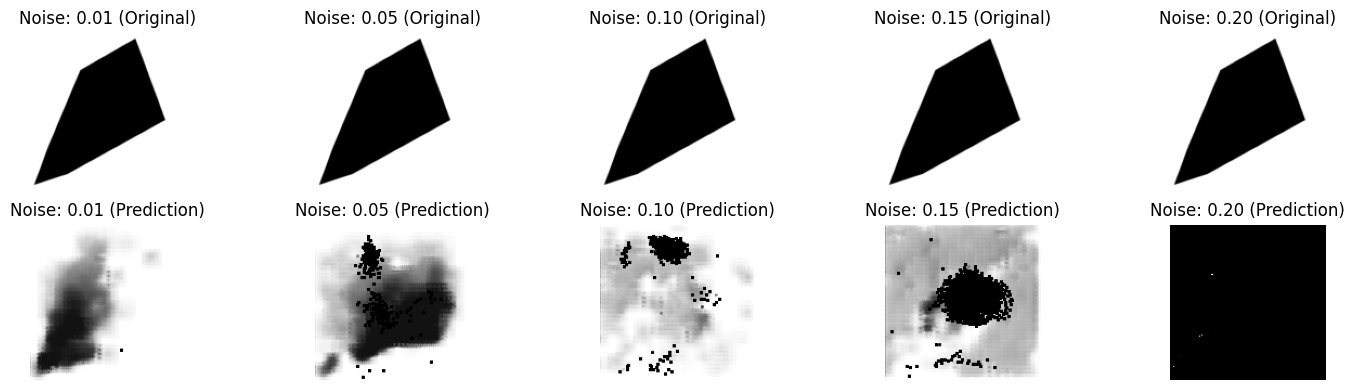

In [ ]:
import matplotlib.pyplot as plt

# 1. Selecciona un dato fijo del conjunto de test.
data_iter = iter(test_loader)
images, csv_data = next(data_iter)

# Selecciona el primer dato
idx = random.randint(0, len(test_loader))
single_image = images[idx].unsqueeze(0).to(device)
single_csv_data = csv_data[idx].unsqueeze(0).to(device)

# Listas para almacenar las imágenes resultantes
original_images = [single_image.squeeze().cpu().numpy()]
noisy_images = []

# 2. Aplícale diferentes niveles de ruido al dato.
for noise_factor in noise_levels:
    noisy_data = add_noise(single_csv_data, noise_factor)

    # 3. Usa el modelo para predecir la salida con y sin ruido.
    with torch.no_grad():
        prediction = model(noisy_data)

    # 4. Visualiza las imágenes resultantes.
    noisy_images.append(prediction.squeeze().cpu().numpy())

# Visualizar
fig, axs = plt.subplots(2, len(noise_levels), figsize=(15, 4))

for i, noise_factor in enumerate(noise_levels):
    axs[0, i].imshow(original_images[0], cmap='gray')
    axs[0, i].set_title(f"Noise: {noise_factor:.2f} (Original)")
    axs[1, i].imshow(noisy_images[i], cmap='gray')
    axs[1, i].set_title(f"Noise: {noise_factor:.2f} (Prediction)")
    axs[0, i].axis('off')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


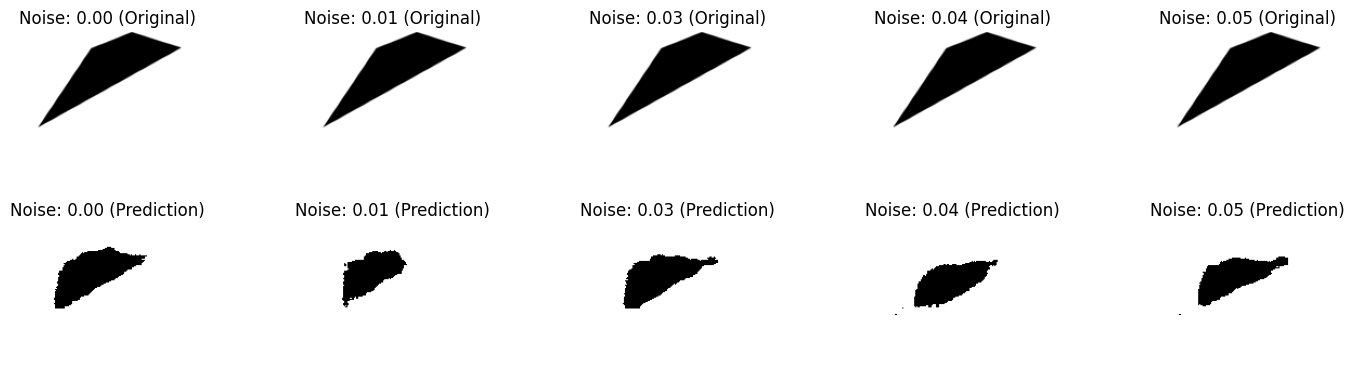

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Función para aplicar el umbral
def apply_threshold(tensor, threshold):
    """Aplica un umbral a un tensor."""
    return (tensor > threshold).float()

# 1. Selecciona un dato fijo del conjunto de test.
data_iter = iter(test_loader)
images, csv_data = next(data_iter)

# Selecciona el primer dato
idx = random.randint(0, len(test_loader))
single_image = images[idx].unsqueeze(0).to(device)
single_csv_data = csv_data[idx].unsqueeze(0).to(device)

# 1. Obtener la predicción del modelo para el dato sin ruido y calcular el umbral óptimo.
with torch.no_grad():
    prediction = model(single_csv_data)

# Buscar el umbral óptimo
thresholds = np.linspace(0, 1, 100)
errors = []

for threshold in thresholds:
    binarized_prediction = apply_threshold(prediction, threshold)
    mse = torch.nn.functional.mse_loss(binarized_prediction, single_image)
    errors.append(mse.item())

optimal_threshold = thresholds[np.argmin(errors)]

# 2. Usar el umbral óptimo para obtener predicciones binarizadas con diferentes niveles de ruido.
predictions_with_noise = []
noise_levels = np.linspace(0,0.05,5) # Ajustar según tus niveles de ruido.

for noise_factor in noise_levels:
    noisy_data = add_noise(single_csv_data, noise_factor)
    with torch.no_grad():
        noisy_prediction = model(noisy_data)
    binarized_noisy_prediction = apply_threshold(noisy_prediction, optimal_threshold)
    predictions_with_noise.append(binarized_noisy_prediction.squeeze().cpu().numpy())

# 3. Visualizar las predicciones en un gráfico con matplotlib.
fig, axs = plt.subplots(2, len(noise_levels), figsize=(15, 4))

for i, noise_factor in enumerate(noise_levels):
    axs[0, i].imshow(single_image.squeeze().cpu().numpy(), cmap='gray')
    axs[0, i].set_title(f"Noise: {noise_factor:.2f} (Original)")
    axs[1, i].imshow(predictions_with_noise[i], cmap='gray')
    axs[1, i].set_title(f"Noise: {noise_factor:.2f} (Prediction)")
    axs[0, i].axis('off')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()
